# Twilight Spotmatch Performance

Study data collected during the [Oct 2021 engineering break](https://docs.google.com/document/d/12J6k8Kj5qTl0AZ7bpl73TmMtvJv8SFjv8ignhJy_R60/edit#heading=h.p6duw2v3x7ur), consisting of 36 FVC exposures processed by spotmatch during evening twilight.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathlib import Path

In [3]:
import scipy.stats

In [4]:
import pandas as pd

In [5]:
import fitsio

In [6]:
import astropy.time
import astropy.table
import astropy.coordinates
import astropy.units as u

In [7]:
import fpoffline.const
import fpoffline.fvc

In [8]:
import desietc.db

In [9]:
DESI = Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [10]:
DBCONFIG = DESI / 'engineering' / 'focalplane' / 'db.yaml'
assert DBCONFIG.exists()
DB = desietc.db.DB(config_name=DBCONFIG)

In [11]:
KPNO = astropy.coordinates.EarthLocation.from_geodetic(lat=31.963972222, lon=-111.599336111, height=2120)

In [12]:
def get_data(night=20211019, expids=(105186, 105187, 105188, 105189)):
    
    path = DATA / str(night)
    meta = []
    first = None
    for expid in expids:
        exptag = str(expid).zfill(8)
        fvcfits = path / exptag / f'fvc-{exptag}.fits.fz'
        assert fvcfits.exists()
        with fitsio.FITS(str(fvcfits)) as hdus:
            extnum = 0
            while True:
                ext = f'F{extnum:04d}'
                if ext not in hdus:
                    break
                
                hdr = hdus[ext].read_header()
                when = astropy.time.Time(hdr['DATE'])
                if first is None:
                    first = when.datetime.isoformat() + '+0000'
                midpt = when + astropy.time.TimeDelta(0.5 * hdr['EXPTIME'], format='sec')

                sun = astropy.coordinates.get_sun(midpt).transform_to(
                    astropy.coordinates.AltAz(location=KPNO, obstime=midpt, pressure=0))
                
                info = dict(expid=expid, extnum=extnum, date=hdr['DATE'], exptime=hdr['EXPTIME'], sunalt=sun.alt.to(u.deg).value)
                
                spots = hdus[f'C{extnum:04d}'].read()
                info['med_mag'] = np.nanmedian(spots['mag'])
                info['med_fwhm'] = np.nanmedian(spots['fwhm'])

                meta.append(info)
                extnum += 1

    meta = astropy.table.Table(meta)

    # Fetch moves from the database for this exposure.
    tables = []
    last = (when + astropy.time.TimeDelta(120, format='sec')).datetime.isoformat() + '+0000'
    print('first', first)
    print(' last', last)
    for petal_loc, petal_id in enumerate(fpoffline.const.PETAL_ID_MAP):
        table_name = f'posmovedb.positioner_moves_p{petal_id}'
        sql = f'''
            select petal_id,device_loc,pos_id,time_recorded,flags,obs_x,obs_y from {table_name} where
            (time_recorded > timestamp '{first}') and (time_recorded < timestamp '{last}')
            order by time_recorded asc
        '''
        table = DB.query(sql, maxrows=50000)
        if len(table) > 0:
            print(f'Read {len(table)} rows for PETAL_LOC {petal_loc}')
        table['petal_loc'] = petal_loc
        table['location'] = 1000*petal_loc + table['device_loc']
        tables.append(table)
    moves = pd.concat(tables, axis='index', ignore_index=True)
    
    return meta, moves

meta, moves = get_data()

first 2021-10-20T01:04:33+0000
 last 2021-10-20T02:17:55+0000
Read 17964 rows for PETAL_LOC 0
Read 18000 rows for PETAL_LOC 1
Read 17964 rows for PETAL_LOC 2
Read 17856 rows for PETAL_LOC 3
Read 17856 rows for PETAL_LOC 4
Read 17928 rows for PETAL_LOC 5
Read 17928 rows for PETAL_LOC 6
Read 17820 rows for PETAL_LOC 7
Read 17928 rows for PETAL_LOC 8
Read 18000 rows for PETAL_LOC 9


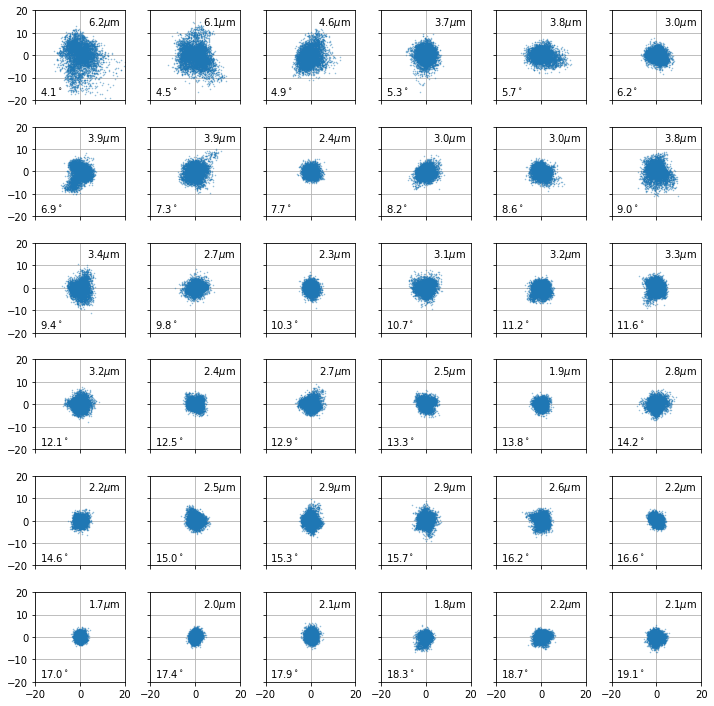

In [13]:
def analyze(meta, moves):
    nexp = len(meta)
    bypos = moves.groupby('location')
    stats = bypos.agg(dict(time_recorded=['count']))
    stats.columns = ['_'.join(a) for a in stats.columns.to_flat_index()]
    assert np.all(stats.time_recorded_count == nexp)
    
    # Use the median of the last 12 exposures as the "true" coordinates.
    stats = bypos.tail(12).groupby('location').agg(dict(obs_x='mean', obs_y='mean'))
    idx = stats.index.to_numpy()
    xtrue, ytrue = np.zeros((2, idx.max() + 1))
    xtrue[idx] = stats.obs_x
    ytrue[idx] = stats.obs_y
    #plt.plot(xtrue[idx], ytrue[idx], '.')
    
    # Calculate residuals for each exposure.
    moves['dx'] = moves.obs_x - xtrue[moves.location]
    moves['dy'] = moves.obs_y - ytrue[moves.location]

    # Calculate and save residuals statistics for each exposure.
    meta['xstd'] = meta['ystd'] = meta['xmad'] = meta['ymad'] = meta['rmad'] = 0.
    fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
    for iexp in range(nexp):
        exp = moves.groupby('location').nth(iexp)
        dx, dy = 1000 * exp.dx, 1000 * exp.dy
        meta['xstd'][iexp] = np.std(dx)
        meta['ystd'][iexp] = np.std(dy)
        meta['xmad'][iexp] = scipy.stats.median_abs_deviation(dx, scale='normal')
        meta['ymad'][iexp] = scipy.stats.median_abs_deviation(dy, scale='normal')
        meta['rmad'][iexp] = np.hypot(meta['xmad'][iexp], meta['ymad'][iexp])
        ax = axes[iexp//6, iexp%6]
        ax.set_aspect(1)
        ax.plot(dx, dy, '.', ms=1, alpha=0.5)
        ax.set_xlim(-20, 20)
        ax.set_ylim(-20, 20)
        ax.grid()
        ax.text(0.05, 0.05, f'{-meta["sunalt"][iexp]:.1f}$^\circ$', transform=ax.transAxes) 
        ax.text(0.95, 0.95, f'{meta["rmad"][iexp]:.1f}$\mu$m', ha='right', va='top', transform=ax.transAxes)
    plt.tight_layout()
    plt.savefig('twilight_dxy.jpg')
    

analyze(meta, moves)

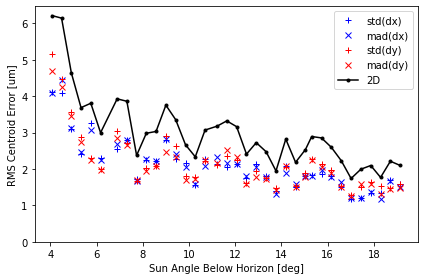

In [14]:
def plot_rms():
    fig = plt.figure(figsize=(6, 4))
    plt.plot(-meta['sunalt'], meta['xstd'], 'b+', label='std(dx)')
    plt.plot(-meta['sunalt'], meta['xmad'], 'bx', label='mad(dx)')
    plt.plot(-meta['sunalt'], meta['ystd'], 'r+', label='std(dy)')
    plt.plot(-meta['sunalt'], meta['ymad'], 'rx', label='mad(dy)')
    plt.plot(-meta['sunalt'], np.hypot(meta['xmad'], meta['ymad']), 'k.-', label='2D')
    plt.ylim(0, None)
    plt.xlabel('Sun Angle Below Horizon [deg]')
    plt.ylabel('RMS Centroid Error [um]')
    plt.legend()
    plt.tight_layout()
    plt.savefig('twilight_rms.jpg')
    
plot_rms()

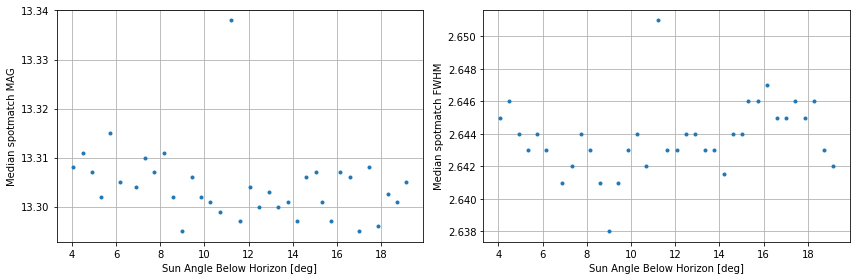

In [15]:
def plot_meta():
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(-meta['sunalt'], meta['med_mag'], '.')
    ax[0].set_xlabel('Sun Angle Below Horizon [deg]')
    ax[0].set_ylabel('Median spotmatch MAG')
    ax[0].grid()
    ax[1].plot(-meta['sunalt'], meta['med_fwhm'], '.')
    ax[1].set_xlabel('Sun Angle Below Horizon [deg]')
    ax[1].set_ylabel('Median spotmatch FWHM')
    ax[1].grid()
    plt.tight_layout()
    plt.savefig('twilight_meta.jpg')
    
plot_meta()

Max arrow length = 23.4 um


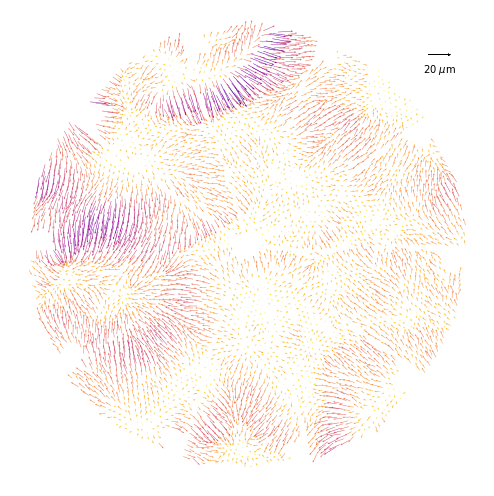

In [16]:
def plot_fp_dxy(iexp=0, scale=0.5, ref=20):
    
    byloc = moves.groupby('location')
    
    stats = byloc.tail(12).groupby('location').agg(dict(obs_x='mean', obs_y='mean'))
    x1, y1 = stats.obs_x.to_numpy(), stats.obs_y.to_numpy()

    exp = byloc.nth(iexp)
    x2, y2 = exp.obs_x.to_numpy(), exp.obs_y.to_numpy()
    
    u = 1e3 * (x2 - x1)
    v = 1e3 * (y2 - y1)
    dr = np.hypot(u, v)
    print(f'Max arrow length = {np.max(dr):.1f} um')
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.axis('off')
    ax.set_aspect(1)
    Q = ax.quiver(x1, y1, u, v, dr, angles='xy', scale=scale, scale_units='xy',
                  headwidth=3, headlength=4, width=0.001, cmap='plasma_r')
    ax.quiverkey(Q, X=0.9, Y=0.9, U=ref, label=f'{ref} $\mu$m', labelpos='S')
    
    plt.tight_layout()
    plt.savefig(f'twilight_quiver_{iexp}.png')
    
plot_fp_dxy(0)

Max arrow length = 17.7 um


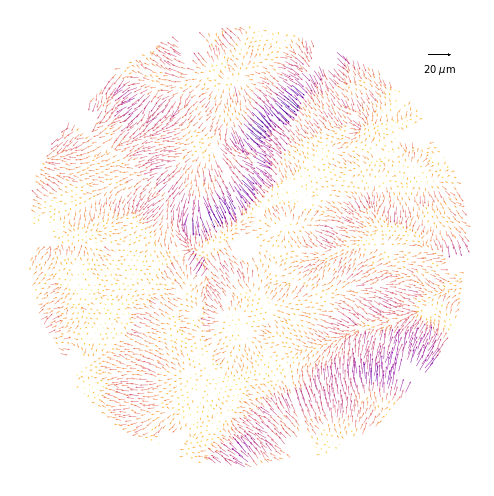

In [17]:
plot_fp_dxy(1)

Max arrow length = 13.4 um


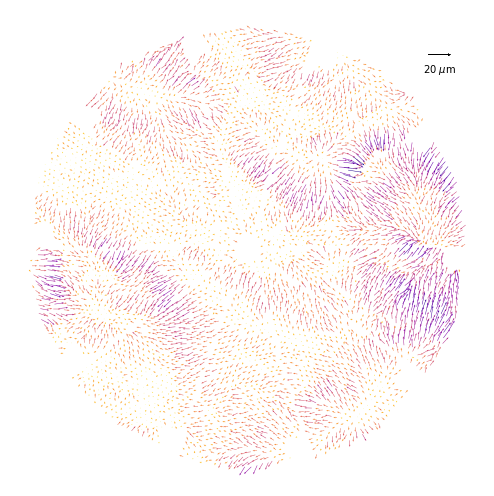

In [18]:
plot_fp_dxy(2)

Max arrow length = 16.5 um


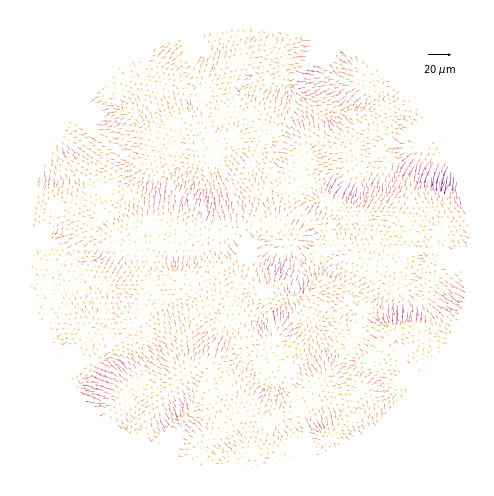

In [19]:
plot_fp_dxy(3)

Max arrow length = 7.1 um


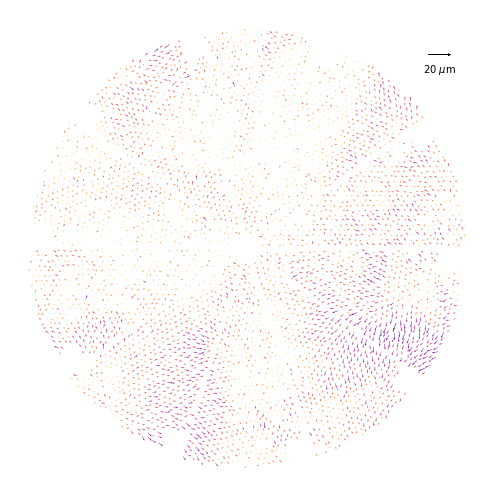

In [20]:
plot_fp_dxy(35)

In [21]:
def plot_fvc(iexp, night=20211019):
    expid = meta['expid'][iexp]
    extnum = meta['extnum'][iexp]
    extname = f'F{extnum:04d}'
    exptag = str(expid).zfill(8)
    fvcfits = DATA / str(night) / exptag / f'fvc-{exptag}.fits.fz'
    assert fvcfits.exists()
    
    data = fitsio.read(str(fvcfits), ext=extname)
    #data = fpoffline.fvc.process_back_illuminated(data)
    data = fpoffline.fvc.process_front_illuminated(data)
    fpoffline.fvc.plot_fvc(data, save=f'twilight_fvc_{iexp}.jpg')

In [22]:
plot_fvc(0)

In [23]:
plot_fvc(35)

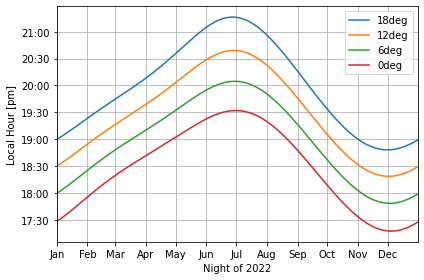

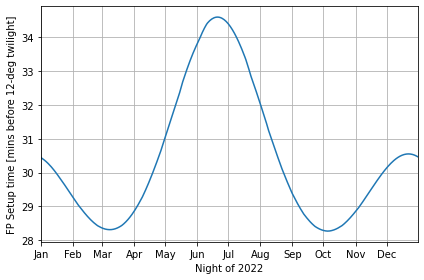

In [24]:
def calc_ephem():
    
    # Calculate local 5pm for each day of 2021.
    t0 = astropy.time.Time('2022-01-01T00:00:00')
    oneday = astropy.time.TimeDelta(24 * 3600, format='sec')    
    fivepm = t0 + np.arange(365).reshape(-1, 1) * oneday

    # Make a 2D grid for each night, starting at 3pm local, with 15min intervals for 5 hours.
    min15 = astropy.time.TimeDelta(15 * 60, format='sec')
    tgrid = fivepm + np.arange(21) * min15
    
    # Calculate the sun altitude at KPNO on this grid.
    sun = astropy.coordinates.get_sun(tgrid).transform_to(
        astropy.coordinates.AltAz(location=KPNO, obstime=tgrid, pressure=0))
    sunalt = -sun.alt.to(u.deg).value

    # Interpolate time of sunset relative to 3pm local on each night.
    trel = np.linspace(5, 10, 21)
    t5pm = np.datetime64('2022-01-01T12:00:00')
    onehr = np.timedelta64(3600, 's')
    sun0 = np.array([np.interp(0, sunalt[d], trel) for d in range(365)])
    sun6 = np.array([np.interp(6, sunalt[d], trel) for d in range(365)])
    sun12 = np.array([np.interp(12, sunalt[d], trel) for d in range(365)])
    sun18 = np.array([np.interp(18, sunalt[d], trel) for d in range(365)])

    # Plot results.
    t = np.arange('2022-01-01', '2023-01-01', dtype='datetime64')
    t1 = np.datetime64('2022-01-01')
    t2 = np.datetime64('2022-12-31')
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(t, t5pm + onehr * sun18, label='18deg')
    plt.plot(t, t5pm + onehr * sun12, label='12deg')
    plt.plot(t, t5pm + onehr * sun6, label='6deg')
    plt.plot(t, t5pm + onehr * sun0, label='0deg')
    plt.xlim(t1, t2)
    xaxis = plt.gca().xaxis
    xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    yaxis = plt.gca().yaxis
    yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    plt.xlabel('Night of 2022')
    plt.ylabel('Local Hour [pm]')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig('twilight_ephem.jpg')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(t, (sun12 - sun6) * 60)
    plt.xlim(t1, t2)
    xaxis = plt.gca().xaxis
    xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    plt.xlabel('Night of 2022')
    plt.ylabel('FP Setup time [mins before 12-deg twilight]')
    plt.grid()
    plt.tight_layout()
    plt.savefig('twilight_sched.jpg')
    
calc_ephem()